In [1]:
import os
import os.path
import sys
import math

In [2]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
import keras
from keras import layers

Using TensorFlow backend.


In [4]:
sys.path.append(os.path.abspath('../dependencies/BristolStockExchange'))
sys.path.append(os.path.abspath('../src'))

# Functions

In [6]:
class RTModel(object):
    def fit(x, transform, y):
        """Fit the model, such that
        transform.T * predict(x) \approx y
        """
        raise NotImplemented("Abstract method")
    
    def predict(x):
        raise NotImplemented("Abstract method")


# Model trainable on differences

In [11]:
def make_diff_model():
    input_layer = keras.layers.Input(shape=(4,))
    foo = keras.layers.Dense(16, activation='relu')(input_layer)
    foo = keras.layers.Dense(64, activation='relu')(foo)
    foo = keras.layers.Dense(16, activation='relu')(foo)
    foo = keras.layers.Dense(1)(foo)
    value_model = keras.Model(inputs=input_layer, outputs=foo)

    input_layer_old = keras.layers.Input(shape=(4,))
    input_layer_new = keras.layers.Input(shape=(4,))
    value_old = value_model(input_layer_old)
    value_new = value_model(input_layer_new)
    diff_layer = keras.layers.Subtract()([value_old, value_new])
    diff_model = keras.Model(inputs=[input_layer_old, input_layer_new], outputs=diff_layer)

    value_model.compile(optimizer='rmsprop', loss='mean_squared_error')
    diff_model.compile(optimizer='rmsprop', loss='mean_squared_error')
    return value_model, diff_model

---
Wait, question: 

# System setup

Model characteristics:
* Continuous inputs, discrete actions
* Discrete events in continuous time

### Flappy Bird

* State: (hight, lower border of the hole, upper border of the hole, time to hole)
* Actions: {fly up, keep falling}
* Reward: time survived

In [12]:
from reinforcement_example.game import Game

In [ ]:
# Play the game
game = Game()
while True:
    print(game.get_state())
    action = int(input())
    game.time_step(action)
    if not game.alive:
        print("DEAD!")
        break

In [6]:
from reinforcement_example.learner import make_model, make_model_elu

In [7]:
from reinforcement_example.learner import AbstractLearner

In [8]:
from reinforcement_example.learner import ScaledModel, ValueToPolicy

In [9]:
from reinforcement_trading.tools import logodds_to_probs, weights_to_inds, random_round

In [11]:
# class SoftPolicy(object):
#     def __init__(self, base, prob_random):
#         self.base = base
#         self.p = prob_random
        
#     def predict(self, states):
#         res = self.base.predict(states)
#         num_actions = res.shape[1]
#         uniform = np.ones(num_actions) / num_actions
#         res = self.p * uniform + (1 - self.p) * res
#         return res

In [11]:
class RandomPolicy(object):
    def __init__(self, numactions):
        self.numactions = numactions
    def predict(self, states):
        return np.zeros((len(states), self.numactions))
    def set_scale(self, scale):
        # Ignore
        pass

In [39]:
class TDLearner3(AbstractLearner):
    def __init__(self, state_dim, num_actions, reward_scale=1.0,
                 minimal_training_experience=200, episodes_between_trainings=50):
        self.state_dim = state_dim
        self.num_actions = num_actions
        self.reward_scale = reward_scale
        self.model_factory = make_diff_model
        self.minimal_training_experience = minimal_training_experience
        self.episodes_between_trainings = episodes_between_trainings
        self.value_model = [ScaledModel(model_factory(state_dim, 1), yscale=reward_scale) for i in range(num_actions)]
        #self.policy = ValueToPolicy(self.value_model, scale=self.reward_scale)
        self.policy = RandomPolicy(self.num_actions)
        self.histories = []
        self.history = []
        # Helper arrays for faster training
        self.states = np.empty((0, self.state_dim))
        self.actions = np.empty(0, dtype=np.int)
        self.rewards = np.empty(0)
        self.logprobs = np.empty(0)
        self.ranges = np.empty((0, 2), dtype=np.int)
        self.actinds = [np.empty(0, dtype=np.int) for i in range(self.num_actions)]

    def move(self, state):
        probs = logodds_to_probs(self.policy.predict(state[np.newaxis, :])[0])
        choice = np.searchsorted(np.cumsum(probs), np.random.rand())
        self.last_action_prob = probs[choice]
        return choice
    
    def _state_value(self, state):
        action_values = np.array([model.predict(state[np.newaxis, :])[0, 0] for model in self.value_model])
        probs = logodds_to_probs(self.policy.predict(state[np.newaxis, :])[0, :])
        return np.dot(probs, action_values)

    def learn(self, state, action, reward, next_state, value_proxy):
        winds = [0] #weights_to_inds(np.array([self.last_action_prob]))
#         self.value_model[action].fit(state[np.newaxis, :][winds, :],
#                                      np.array([[reward + self._state_value(next_state)]])[winds],
#                                      verbose=False)
        self.history.append((np.array(state), action, reward, self.last_action_prob))

    def learn_last(self, state, action, reward):
        winds = [0] #weights_to_inds(np.array([self.last_action_prob]))
#         self.value_model[action].fit(state[np.newaxis, :][winds, :],
#                                      np.array([[reward]])[winds],
#                                      verbose=False)
        self.history.append((np.array(state), action, reward, self.last_action_prob))
        self.histories.append(self.history)
        self.history = []
        if len(self.histories) >= self.minimal_training_experience and \
           (len(self.histories) - self.minimal_training_experience) % self.episodes_between_trainings == 0:
            self._update_value_model()

    def _update_value_model(self):
        # Update data structures
        dsize = len(self.states)
        for i in range(len(self.ranges), len(self.histories)):
            last_states, last_actions, last_rewards, last_actionprob = zip(*self.histories[i][::-1])
            self.ranges = np.concatenate([self.ranges, np.array([[dsize, dsize + len(last_states)]])])
            dsize += len(last_states)
            self.states = np.concatenate([self.states, np.array(last_states)], axis=0)
            self.actions = np.concatenate([self.actions, np.array(last_actions, dtype=np.int)])
            self.rewards = np.concatenate([self.rewards, last_rewards])
            #self.logprobs = np.concatenate([self.logprobs, [0], np.log(last_actionprob)[:-1]])
            #self.actinds = [np.arange(len(self.actions))[self.actions == i] for i in range(self.num_actions)]
            self.actinds = [np.concatenate([self.actinds[i],
                                            np.arange(dsize - len(last_states), dsize)
                                                [self.actions[dsize - len(last_states):dsize] == i]])
                            for i in range(self.num_actions)]
        # Training
        policy_probs = logodds_to_probs(self.policy.predict(self.states))
        #policy_logprobs = np.log(policy_probs[np.arange(dsize), self.actions])
        #policy_cumlogprobs = np.zeros(dsize)
        #for start, end in self.ranges:
        #    policy_cumlogprobs[start + 1:end] = np.cumsum(policy_logprobs[start:end - 1])
        goon = True
        #last_prediction = None
        #while goon:
        model_factory = self.model_factory
        self.value_model = [ScaledModel(model_factory(self.state_dim, 1), yscale=self.reward_scale)
                            for i in range(self.num_actions)]
        for value_iter in range(300):
            predicted_state_action_value = np.array([model.predict(self.states)[:, 0] for model in self.value_model]).T
            predicted_state_value = np.sum(policy_probs * predicted_state_action_value, axis=1)
            response = np.empty(self.rewards.shape)
            response[:] = self.rewards
            for start, end in self.ranges:
                response[start + 1:end] += predicted_state_value[start:end - 1]
            predicted_value = predicted_state_action_value[np.arange(dsize), self.actions]
            # weights = np.exp(policy_logprobs - self.logprobs)
            for action in range(self.num_actions):
                inds = self.actinds[action]  #[weights_to_inds(weights[self.actinds[action]])]
                if len(inds) > 0:
                    self.value_model[action].fit(self.states[inds, :], response[inds],
                                                 epochs=10#,
                                                 #callbacks=[keras.callbacks.EarlyStopping(monitor='loss', patience=10)]
                                                )
            ## What is eps?
            #if last_prediction is not None and
            #   np.max(np.abs(predicted_state_action_value - last_prediction)) < eps:
            #        goon = False
            #last_prediction = predicted_state_action_value
        # Policy scale
        self.policy = ValueToPolicy(self.value_model, scale=self.reward_scale)
        #mse = np.dot(weights, (predicted_value - response) ** 2) / np.sum(weights)
        #self.policy.set_scale(self.reward_scale / len(self.histories) + np.sqrt(mse))
        #self.policy.set_scale(self.reward_scale / np.sqrt(len(self.histories)))
        return


In [23]:
from reinforcement_example.learner import train_play

In [40]:
game = Game()
learner = TDLearner2(4, 2, reward_scale=game.mean_time_to_hole)

In [188]:
learner2 = TDLearner(4, 2, reward_scale=game.mean_time_to_hole)
learner2.histories = learner.histories
learner2.value_model = learner.value_model
learner2._update_value_model()
learner_bak = learner
learner = learner2


Epoch 1/10
29552/29552 [==============================] - 2s 71us/step - loss: 41.9196
Epoch 2/10
29552/29552 [==============================] - 2s 80us/step - loss: 41.0478
Epoch 3/10
29552/29552 [==============================] - 2s 77us/step - loss: 41.7494
Epoch 4/10
29552/29552 [==============================] - 2s 71us/step - loss: 42.0738
Epoch 1/10
35995/35995 [==============================] - 3s 78us/step - loss: 22.3180
Epoch 2/10
35995/35995 [==============================] - 3s 72us/step - loss: 22.4159
Epoch 3/10
35995/35995 [==============================] - 3s 74us/step - loss: 22.1707
Epoch 4/10
35995/35995 [==============================] - 3s 73us/step - loss: 22.7951
Epoch 5/10
35995/35995 [==============================] - 3s 76us/step - loss: 22.1064
Epoch 6/10
35995/35995 [==============================] - 3s 78us/step - loss: 22.5506
Epoch 7/10
35995/35995 [==============================] - 3s 72us/step - loss: 22.3347


In [ ]:
for i in range(10):
    learner._update_value_model()

In [15]:
def show_history(history):
    x = np.zeros(len(history))
    x[1:] = np.cumsum([info[2] for info in history[:-1]])
    y = np.array([info[0][0] for info in history])
    gates = dict()
    for i in range(len(history)):
        gx = x[i] + history[i][0][3]
        gl = history[i][0][1]
        gu = history[i][0][2]
        gates[np.round(gx)] = (gx, gl, gu)
    plt.plot(x, y, '-*')
    for gx, gl, gu in gates.values():
        plt.plot([gx, gx], [0, gl], 'r-')
        plt.plot([gx, gx], [gu, 100], 'r-')

58.54143222571392

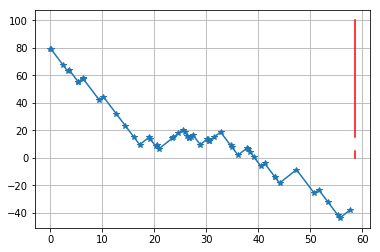

In [32]:
fooh, foor = train_play(Game(), learner)
show_history(fooh)
plt.grid(True)
foor

In [163]:
fooh[-1]

(array([53.92746374, 87.94064598, 88.2871137 ,  0.13904493]),
 1,
 0.13904492872458163)

In [41]:
history = []

In [ ]:
for i in range(10000):
    history.append(train_play(Game(), learner)[1])
    if len(history) % 100 == 0:
        print(len(history))
    if os.path.exists("002_reinforcement_example_v8_stop"):
        break
plt.plot(np.cumsum(history))

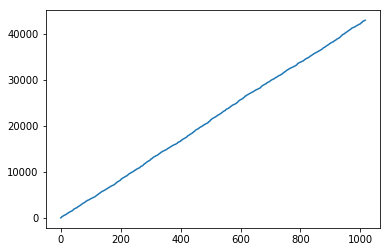

In [53]:
plt.plot(np.cumsum(history))

In [ ]:
for i in range(100):
    history.append(train_play(Game(), learner)[1])
plt.plot(np.cumsum(history))

In [51]:
np.mean(history)

41.017197365601405

In [172]:
len(history)

1184

In [107]:
# import pickle
# with open('002_reinforcement_example_v2_learner.pickle', 'wb') as f:
#     pickle.dump({
#         'histories': learner.histories,
#         'value_model': [
#             {
#                 'config': model.get_config(),
#                 'weights': model.get_weights()
#             }
#             for model in learner.value_model
#         ]
#     }, f)

AttributeError: 'ScaledModel' object has no attribute 'get_config'

In [169]:
import pickle
with open('002_reinforcement_example_v5_learner_v3.pickle', 'wb') as f:
    pickle.dump(dict([(foo, learner.__dict__[foo]) for foo in learner.__dict__
                      if foo != "value_model" and foo != 'policy'] +
                     [("value_model", [{
                         "xscale": model.xscale,
                         "yscale": model.yscale,
                         "config": model.model.get_config(),
                         "weights": model.model.get_weights()
                     } for model in learner.value_model])]), f)

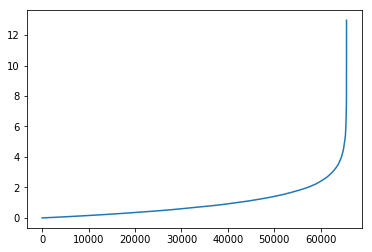

In [179]:
plt.plot(np.sort(learner.rewards))

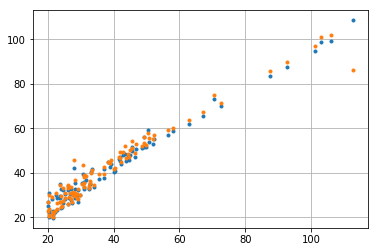

In [50]:
foo = np.zeros((100, 4))
for i in range(foo.shape[0]):
    foo[i, :4] = Game().get_state()
fooy0 = learner.value_model[0].predict(foo).reshape(-1)
fooy1 = learner.value_model[1].predict(foo).reshape(-1)
plt.plot(foo[:, 3], fooy0, '.')
plt.plot(foo[:, 3], fooy1, '.')
plt.grid()

In [56]:
np.min(learner.rewards)

4.490789154299005e-06

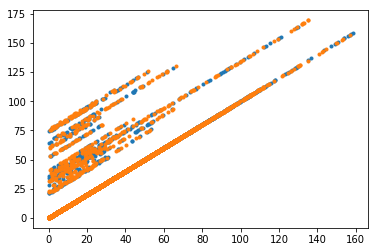

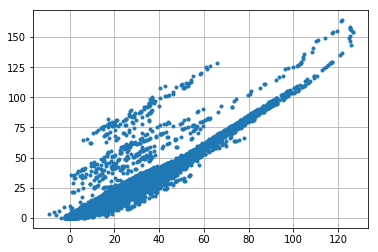

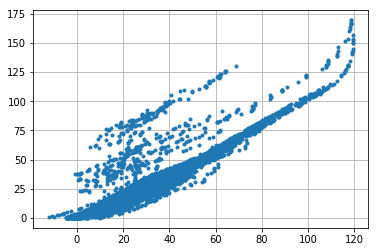

In [49]:
        cumrewards = np.empty(len(learner.states))
        for start, end in learner.ranges:
            cumrewards[start:end] = np.cumsum(learner.rewards[start:end])
        for action in range(learner.num_actions):
            X = learner.states[learner.actinds[action], :]
            Y = cumrewards[learner.actinds[action]]
            plt.plot(X[:, 3], Y, '.')
        for action in range(learner.num_actions):
            X = learner.states[learner.actinds[action], :]
            Y = cumrewards[learner.actinds[action]]
            plt.figure()
            plt.plot(learner.value_model[action].predict(X), Y, '.')
            #plt.title('Prediction vs response, RMS = {}'.format(learner.value_model[action].evaluate(X[inds], Y[inds])))
            plt.grid(True)

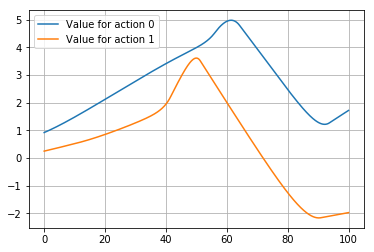

In [48]:
foo_heights = np.linspace(0, 100, 1000)
foo_states = np.empty((len(foo_heights), 4))
foo_states[:, 0] = foo_heights
foo_states[:, 1] = 45
foo_states[:, 2] = 55
foo_states[:, 3] = 1
for action in range(learner.num_actions):
    foo_v = learner.value_model[action].predict(foo_states)
    plt.plot(foo_heights, foo_v, label="Value for action {}".format(action))
plt.grid(True)
plt.legend()

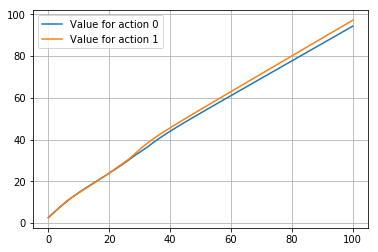

In [47]:
foo_dists = np.linspace(0, 100)
foo_states = np.empty((len(foo_dists), 4))
foo_states[:, 0] = 50
foo_states[:, 1] = 45
foo_states[:, 2] = 55
foo_states[:, 3] = foo_dists
for action in range(learner.num_actions):
    foo_v = learner.value_model[action].predict(foo_states)
    plt.plot(foo_dists, foo_v, label="Value for action {}".format(action))
plt.legend()
plt.grid(True)

In [195]:
learner.policy.scale

1.1571137082807434

In [61]:
dy = learner.states[:, 0] - 0.5 * (learner.states[:, 1] + learner.states[:, 2])
ybins = np.linspace(-100, 100, 30)
xbins = np.linspace(-60, 0, 30)
totals = np.zeros((len(xbins) + 1, len(ybins) + 1))
counts = np.zeros((len(xbins) + 1, len(ybins) + 1))
xi = np.searchsorted(xbins, -learner.states[:, 3])
yi = np.searchsorted(ybins, dy)
for i in range(len(learner.states)):
    totals[xi[i], yi[i]] += learner.cumrewards[i]
    counts[xi[i], yi[i]] += 1
plt.imshow((totals / counts).T,
           origin = 'lower',
           aspect='auto',
           extent=(np.min(xbins), np.max(xbins), np.min(ybins), np.max(ybins)))

AttributeError: 'TDLearner' object has no attribute 'cumrewards'

/usr/lib64/python3.5/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


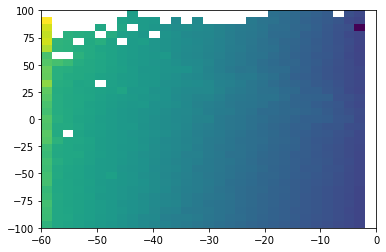

In [46]:
dy = learner.states[:, 0] - 0.5 * (learner.states[:, 1] + learner.states[:, 2])
predictions = np.mean([model.predict(learner.states).reshape(-1) for model in learner.value_model], axis=0)
ybins = np.linspace(-100, 100, 30)
xbins = np.linspace(-60, 0, 30)
totals = np.zeros((len(xbins) + 1, len(ybins) + 1))
counts = np.zeros((len(xbins) + 1, len(ybins) + 1))
xi = np.searchsorted(xbins, -learner.states[:, 3])
yi = np.searchsorted(ybins, dy)
for i in range(len(learner.states)):
    totals[xi[i], yi[i]] += predictions[i]
    counts[xi[i], yi[i]] += 1
plt.imshow((totals / counts).T,
           origin = 'lower',
           aspect='auto',
           extent=(np.min(xbins), np.max(xbins), np.min(ybins), np.max(ybins)))

In [44]:
def mean_heatmap(x, y, z, xbins, ybins):
    xi = np.searchsorted(xbins, x)
    yi = np.searchsorted(ybins, y)
    totals = np.zeros((len(xbins) + 1, len(ybins) + 1))
    counts = np.zeros((len(xbins) + 1, len(ybins) + 1))
    for i in range(len(learner.states)):
        totals[xi[i], yi[i]] += z[i]
        counts[xi[i], yi[i]] += 1
    plt.imshow((totals / counts).T,
               origin = 'lower',
               aspect='auto',
               extent=(np.min(xbins), np.max(xbins), np.min(ybins), np.max(ybins)))
    plt.colorbar()
    plt.contour(np.linspace(xbins[0], xbins[-1], len(xbins) + 1),
                np.linspace(ybins[0], ybins[-1], len(ybins) + 1),
                (totals / counts).T,
                colors='k')


/usr/lib64/python3.5/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/usr/lib64/python3.5/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


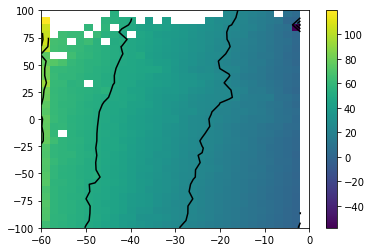

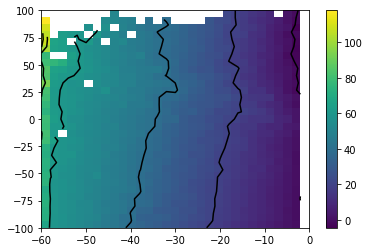

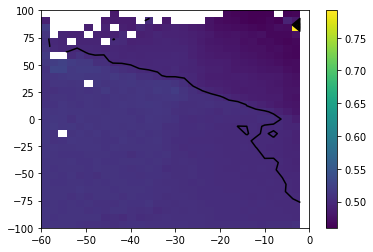

In [45]:
ybins = np.linspace(-100, 100, 30)
xbins = np.linspace(-60, 0, 30)
dy = learner.states[:, 0] - 0.5 * (learner.states[:, 1] + learner.states[:, 2])
for action in range(learner.num_actions):
    predictions = learner.value_model[action].predict(learner.states).reshape(-1)
    plt.figure()
    mean_heatmap(-learner.states[:, 3], dy, predictions, xbins, ybins)

predictions = logodds_to_probs(learner.policy.predict(learner.states))[:, 1]
plt.figure()
mean_heatmap(-learner.states[:, 3], dy, predictions, xbins, ybins)

In [64]:
np.min(predictions), np.max(predictions)

(161.00038, 161.0004)

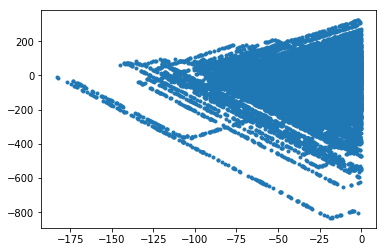

In [178]:
dy = learner.states[:, 0] - 0.5 * (learner.states[:, 1] + learner.states[:, 2])
plt.plot(-learner.states[:, 3], dy, '.')
plt.ylabel("Hieght relative to the hole")
plt.xlabel("Distance to the wall")

#### Test the ability of the neural network to learn...

In [ ]:
model = make_model(6, 1)

In [ ]:
data = np.random.rand(6000).reshape((1000, 6)) * 3

In [ ]:
for row in data:
    model.train_on_batch(row[np.newaxis, :], row[[-1]])

In [ ]:
foo = np.random.rand(600).reshape((100, 6)) * 3
fooy = model.predict(foo)
plt.plot(foo[:, -1], fooy.reshape(-1), '.')
plt.grid(True)